In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Mapping $S_1$ and $S_6$ using $Z_{C,red}$

We have the following equations:

\begin{align}
S_1 =  \frac{1}{2} (Z_{C,ox} - Z_{C,red}) \\
S_6 = \frac{1}{2} (Z_{C,B} - Z_{C,red}) \\
\end{align}

We want to vary $Z_{C,red}$ and effectively set $S_1$ and $S_6$ from it.

In [3]:
ZCred = 0.0 # setting a dummy ZCred, assuming glucose as a reference carbon source
ZCox = +4.0 # assuming CO2 as the reference metabolic product
ZCB = 0.0   # assuming glucose as reference carbon source, and reference S6 of 0

def set_stoichs(ZCox, ZCB, ZCred):
    S1 = 0.5 * (ZCox - ZCred)
    S6 = 0.5 * (ZCB - ZCred)
    return S1, S6

In [4]:
S1, S6 = set_stoichs(ZCox, ZCB, ZCred)

In [5]:
S1, S6

(2.0, 0.0)

# Respiratory heterotrophy model

In [6]:
eps = 1e-10
tau = 1e0
S2 = 2.

In [7]:
rho  = 1.0
qMc = 12.0

In [8]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = eps
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP

    # concentration dynamics are in χ units; NADH and ATP take values in mol/gC
    # where 1 mM = 1e-3 mol/l = 6e-6 mol/gC
    N_KM = NADH/KM
    A_KM = ATP/KM
    
    # Writing down the MM term for NADH and ATP explicitly.
    fN = N_KM / (1 + N_KM)
    fA = A_KM / (1 + A_KM)

    nu_cat = rho * phi_cat * gamma_cat_inv * tau
    nu_resp = rho * phi_resp * gamma_resp_inv * tau
    nu_ana = rho * phi_ana * gamma_ana_inv * tau
    
    mu = qMc * nu_ana
    Jh = rho * phi_h * gamma_hom_inv * tau
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    dNADH = S1 * nu_cat - S2 * nu_resp - S6 * nu_ana - mu * (NADH + NAD)
    # dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana  - Jh - maint - mu * ATP
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

### Parameters

In [9]:
# gamma inverses are in /hr units.
gamma_cat_inv = 5e-5*3600
gamma_resp_inv = 5e-5*3600
gamma_ana_inv = 5e-5*3600
gamma_hom_inv = 5e-5*3600

phi_cat = 0.3
phi_ana = 0.4
phi_resp = 0.03
phi_h = 0.0
phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)

# maintenance energy
maint = 0.01

# Default params: reliance on respiration.
S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
S5 = 0.3    # ATP cost of anabolism

### Initial conditions

In [10]:
# concentrations in χ units; initial values set arbitarily.
Corg0 = 1e2
NADH0 = 1e2
O20 = 1e1
ATP0 = 1e2

# KM is in χ units, mol/gC (new supplement section 2.1: typical χ values)
KM = 6e-7   # 1e-3 mol/L is 6e-6 mol/gC; 6e-7 is thus for a KM of 100 μM.
r1 = 10.
r2 = 0.1

### Dynamics

In [11]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e2
t = np.logspace(-4, 2, 1000 )

In [12]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    # concentration dynamics are in χ units; NADH and ATP take values in mol/gC
    # where 1 mM = 1e-3 mol/l = 6e-6 mol/gC
    N_KM = NADH/KM
    A_KM = ATP/KM
    
    # Writing down the MM term for NADH and ATP explicitly.
    fN = N_KM / (1 + N_KM)
    fA = A_KM / (1 + A_KM)

    nu_cat = rho * phi_cat * gamma_cat_inv * tau
    nu_resp = rho * phi_resp * gamma_resp_inv * tau
    nu_ana = rho * phi_ana * gamma_ana_inv * tau
    
    mu = qMc * nu_ana
    Jh = rho * phi_h * gamma_hom_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana, mu])

In [13]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

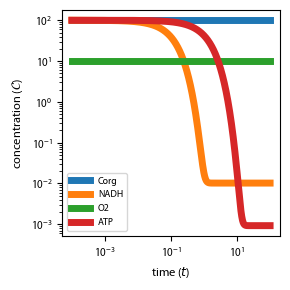

In [14]:
fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [15]:
def is_steady(y_sol, eps):
    # Check if solution has reached steady state
    # by checking if the values at index 1 and -1 are constant and above eps
    return y_sol[1,-1] > eps and y_sol[-1,-1] > eps and np.abs(np.diff(y_sol[1,:]))[-1] < eps and np.abs(np.diff(y_sol[-1,:]))[-1] < eps

In [16]:
is_steady(y_sol, 1e-4)

True

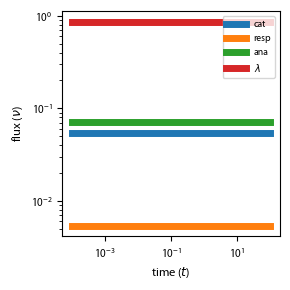

In [17]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(4):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana', r'$\lambda$' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Variable $Z_{C,red}$

In [18]:
np.linspace(-5, 10, 8)

array([-5.        , -2.85714286, -0.71428571,  1.42857143,  3.57142857,
        5.71428571,  7.85714286, 10.        ])

In [19]:
ZCred

0.0

In [26]:
LB_CONC = eps  # threshold concentration set to arbitrary small value
UB_CONC = 1e-2   # threshold concentration set to reasonable value

opt_atps = []
opt_nadhs = []
opt_mus = []
opt_phi_cats = []
opt_phi_resps = []
opt_phi_anas = []
opt_phi_hs = []
opt_phi_os = []
zcreds = []
zcbs = []
s6s = []
s4s = []
s3s = []

# initial concentrations in KM units
NADH0 = 1e2
ATP0 = 1e2

eps = 1e-4 # arbitrary small value

# Set fixed values for phi_o_min and maintenance
MIN_PHI_O = 0.3
maint = 0.00

SAMPLING_DENSITY = 25

S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
for S4 in [1.0, 0.1]:
    for S3 in [0.5, 0.1]:
        for ZCred in np.linspace(-5, 10, 50):
            # setting stoichiometries
            S1, S6 = set_stoichs(ZCox, ZCB, ZCred)

            anas_to_sample = np.linspace(0.00, 0.9, SAMPLING_DENSITY)
            resps_to_sample = np.linspace(0.00, 0.7, SAMPLING_DENSITY)
            cats_to_sample = np.linspace(0.00, 0.4, SAMPLING_DENSITY)

            allatps, allnadhs, allmus, allphis = [], [], [], []
            for phi_ana in anas_to_sample:
                for phi_resp in resps_to_sample:
                    for phi_cat in cats_to_sample:
                        phi_h = 0.0
                        phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)
                        # make sure that phi_o is above the minimum value.
                        if phi_o < MIN_PHI_O:
                            continue

                        y0 = np.array([Corg0, NADH0, O20, ATP0])
                        NUM_METS = len(y0)

                        # Evaluation time
                        TFINAL = 1e6
                        t = np.logspace(-4, 6, 1000)

                        y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

                        if is_steady(y_sol, eps):
                            nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

                            allatps.append(y_sol[-1, -1])
                            allnadhs.append(y_sol[1, -1])
                            allmus.append(nus[-1, -1])
                            allphis.append([phi_cat, phi_resp, phi_ana, phi_h, phi_o])

            if len(allmus) > 0:
                # Filter out solutions with ATP or NADH below LB_CONC
                valid_indices = [i for i, (atp, nadh) in enumerate(zip(allatps, allnadhs)) if atp >= LB_CONC and nadh >= LB_CONC and atp <= UB_CONC and nadh <= UB_CONC]

                allatps = [allatps[i] for i in valid_indices]
                allnadhs = [allnadhs[i] for i in valid_indices]
                allmus = [allmus[i] for i in valid_indices]
                allphis = [allphis[i] for i in valid_indices]

                # Check if any valid solutions remain
                if len(allmus) > 0:
                    mus = np.array(allmus)
                    max_index = np.argmax(mus)  # finding growth-optimal index
                    phi_cat, phi_resp, phi_ana, phi_h, phi_o = allphis[max_index]  # optimal phis

                    # storing optimized ATP*, NADH* and optimal phi_resp.
                    opt_atps.append(allatps[max_index])
                    opt_nadhs.append(allnadhs[max_index])
                    opt_phi_cats.append(phi_cat)
                    opt_phi_resps.append(phi_resp)
                    opt_phi_anas.append(phi_ana)
                    opt_phi_hs.append(phi_h)
                    opt_phi_os.append(phi_o)
                    opt_mus.append(allmus[max_index])
                    zcreds.append(ZCred)
                    zcbs.append(ZCB)
                    s6s.append(S6)
                    s4s.append(S4)
                    s3s.append(S3)
                else:
                    # storing optimized ATP*, NADH* and optimal phi_resp.
                    opt_atps.append(0.0)
                    opt_nadhs.append(0.0)
                    opt_phi_cats.append(0.0)
                    opt_phi_resps.append(0.0)
                    opt_phi_anas.append(0.0)
                    opt_phi_hs.append(0.0)
                    opt_phi_os.append(0.0)
                    opt_mus.append(0.0)
                    zcreds.append(ZCred)
                    zcbs.append(ZCB)
                    s6s.append(S6)
                    s4s.append(S4)
                    s3s.append(S3)


df = pd.DataFrame({'atps': opt_atps,
                   'nadhs': opt_nadhs,
                   'zcred': zcreds,
                   'zcb': zcbs,
                   's6s': s6s,
                   's4s': s4s,
                   's3s': s3s,
                   'mus': opt_mus,
                   'opt_phi_cat': opt_phi_cats,
                   'opt_phi_resp': opt_phi_resps,
                   'opt_phi_ana': opt_phi_anas,
                   'opt_phi_h': opt_phi_hs,
                   'opt_phi_o': opt_phi_os
                   })


In [27]:
df

,atps,nadhs,zcred,zcb,s6s,s4s,s3s,mus,opt_phi_cat,opt_phi_resp,opt_phi_ana,opt_phi_h,opt_phi_o
0,0.000253,0.001722,-5.000000,0.0,2.500000,1.0,0.5,0.891,0.25,0.0,0.4125,0.0,0.3375
1,0.000253,0.002179,-4.693878,0.0,2.346939,1.0,0.5,0.891,0.25,0.0,0.4125,0.0,0.3375
2,0.000253,0.002635,-4.387755,0.0,2.193878,1.0,0.5,0.891,0.25,0.0,0.4125,0.0,0.3375
3,0.000253,0.003092,-4.081633,0.0,2.040816,1.0,0.5,0.891,0.25,0.0,0.4125,0.0,0.3375
4,0.000253,0.003549,-3.775510,0.0,1.887755,1.0,0.5,0.891,0.25,0.0,0.4125,0.0,0.3375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.000000,8.775510,0.0,-4.387755,0.1,0.1,0.000,0.00,0.0,0.0000,0.0,0.0000
196,0.000000,0.000000,9.081633,0.0,-4.540816,0.1,0.1,0.000,0.00,0.0,0.0000,0.0,0.0000
197,0.000000,0.000000,9.387755,0.0,-4.693878,0.1,0.1,0.000,0.00,0.0,0.0000,0.0,0.0000
198,0.000000,0.000000,9.693878,0.0,-4.846939,0.1,0.1,0.000,0.00,0.0,0.0000,0.0,0.0000


In [28]:
# df.to_csv('../data/zcred_sweep_1.csv', index=False)

In [6]:
df = pd.read_csv('zcred_sweep_2.csv', index_col=False)

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


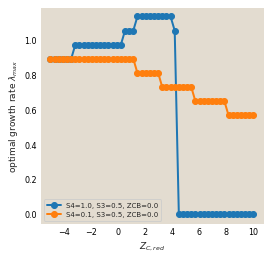

In [7]:
# Initialize the plot
plt.figure(figsize=(4, 4))

# Choosing parameter values.
s4s_values = [1.0, 0.1]
s3s_values = [0.5, 0.5]
zcb_values = [0.0, 0.0]

# Loop through the values and plot
for s4s_val, s3s_val, zcb_val in zip(s4s_values, s3s_values, zcb_values):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], marker='o', linestyle='-', label=f'S4={s4s_val}, S3={s3s_val}, ZCB={zcb_val}')

# Add labels and title
plt.xlabel(r'$Z_{C,red}$')
plt.ylabel('optimal growth rate ' + r'$\lambda_{max}$')

# Add grid and legend
plt.legend()

# Show the plot
plt.show()

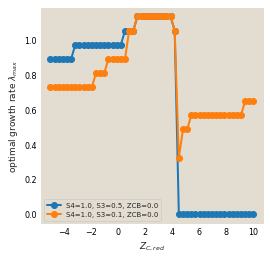

In [8]:
# Initialize the plot
plt.figure(figsize=(4, 4))

# Define the values you want to filter by
s4s_values = [1.0, 1.0]  # Replace with the actual values
s3s_values = [0.5, 0.1]  # Replace with the actual values
zcb_values = [0.0, 0.0]  # Replace with the actual values

# Loop through the values and plot
for s4s_val, s3s_val, zcb_val in zip(s4s_values, s3s_values, zcb_values):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], marker='o', linestyle='-', label=f'S4={s4s_val}, S3={s3s_val}, ZCB={zcb_val}')

# Add labels and title
plt.xlabel(r'$Z_{C,red}$')
plt.ylabel('optimal growth rate ' + r'$\lambda_{max}$')

# Add grid and legend
plt.legend()

# Show the plot
plt.show()

# Visually consistent plots

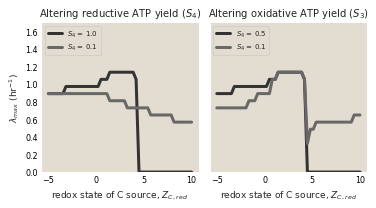

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(5.3, 3), sharey=True)
pal = sns.color_palette('Greys_r', n_colors=5)

# PANEL Α
# Variable S4 = respiratory ATP yield
plt.sca(axs[0])
plt.title('Altering reductive ATP yield ($S_4$)')

# Choosing parameter values.
s4s_values = [1.0, 0.1]
s3s_values = [0.5, 0.5]
zcb_values = [0.0, 0.0]

# Loop through the values and plot
for i, (s4s_val, s3s_val, zcb_val) in enumerate(zip(s4s_values, s3s_values, zcb_values)):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], lw=3,
            color=pal[i], label='$S_4$ = {0:.1f}'.format(s4s_val))


plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# PANEL B
# Variable S3 = oxidative ATP yield
plt.sca(axs[1])
plt.title('Altering oxidative ATP yield ($S_3$)')

# Choosing parameter values.
s4s_values = [1.0, 1.0]
s3s_values = [0.5, 0.1]
zcb_values = [0.0, 0.0]

# Loop through the values and plot
for i, (s4s_val, s3s_val, zcb_val) in enumerate(zip(s4s_values, s3s_values, zcb_values)):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], lw=3,
            color=pal[i], label='$S_4$ = {0:.1f}'.format(s3s_val))

plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

plt.ylim(0, 1.7)

plt.tight_layout()
plt.savefig('supp_figs/Akshit_FigS1.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()